# Train Revenue Prediction Model

This model predic the revenue of the next quarter of all B3 listed companies.

## Import Packages

In [27]:
import os
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Constants & Settings

In [2]:
DATA_SOURCE_FOLDER = "/workspaces/valuation/data/staging/numpy"
TENSORBOARD_LOG_DIR = f"/workspaces/valuation/data/staging/tensorboard/{datetime.now().strftime('%Y-%m-%d (%H:%Mh)')}"

# device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=TENSORBOARD_LOG_DIR)

## Read Preprocessed Data

In [3]:
X_train = np.load(os.path.join(DATA_SOURCE_FOLDER, 'X_train.npy'))
y_train = np.load(os.path.join(DATA_SOURCE_FOLDER, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_SOURCE_FOLDER, 'X_test.npy'))
y_test = np.load(os.path.join(DATA_SOURCE_FOLDER, 'y_test.npy'))

## Hiperparameter

In [4]:
INPUT_SIZE = X_train.shape[2]
OUTPUT_SIZE = 1
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20
BATCH_SIZE = 64
SHUFFLE_TRAIN_DATA = False
SHUFFLE_TEST_DATA = False

## Define the LSTM model

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


## Normalize the data

In [6]:
# Apply MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = y_scaler.transform(y_test)

## Create dataset and dataloaders

In [7]:
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN_DATA)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TEST_DATA)


## Validation function

In [8]:
def validation(model, criterion, test_loader):
    # Testing loop
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        
        test_loss /= len(test_loader)
        return test_loss

## Prediction function

In [16]:
def predict(model, data):
    model.eval()
    data = torch.tensor(data, dtype=torch.float32)
    data = data.to(DEVICE)
    with torch.no_grad():
        outputs = model(data)
    return outputs.cpu().numpy()

## Model, loss function, optimizer

In [9]:
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


## Trainig the Model

In [10]:
# Training the model
for epoch in range(NUM_EPOCHS):
    
    model.train()
    optimizer.zero_grad()
    avg_loss = 0

    for data, targets in train_loader:
        data, targets = data.to(DEVICE), targets.to(DEVICE)
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    avg_test_loss = validation(model, criterion, test_loader)

    # Log the losses to TensorBoard
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    writer.add_scalar('Loss/Test', avg_test_loss, epoch)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Avg Train Loss: {avg_loss:.4f}, Avg Test Loss: {avg_test_loss:.4f}')


Epoch [1/20], Avg Train Loss: 0.0016, Avg Test Loss: 0.0041
Epoch [2/20], Avg Train Loss: 0.0022, Avg Test Loss: 0.0014
Epoch [3/20], Avg Train Loss: 0.0008, Avg Test Loss: 0.0016
Epoch [4/20], Avg Train Loss: 0.0008, Avg Test Loss: 0.0017
Epoch [5/20], Avg Train Loss: 0.0010, Avg Test Loss: 0.0015
Epoch [6/20], Avg Train Loss: 0.0007, Avg Test Loss: 0.0015
Epoch [7/20], Avg Train Loss: 0.0008, Avg Test Loss: 0.0014
Epoch [8/20], Avg Train Loss: 0.0007, Avg Test Loss: 0.0014
Epoch [9/20], Avg Train Loss: 0.0007, Avg Test Loss: 0.0014
Epoch [10/20], Avg Train Loss: 0.0009, Avg Test Loss: 0.0015
Epoch [11/20], Avg Train Loss: 0.0011, Avg Test Loss: 0.0015
Epoch [12/20], Avg Train Loss: 0.0007, Avg Test Loss: 0.0014
Epoch [13/20], Avg Train Loss: 0.0007, Avg Test Loss: 0.0013
Epoch [14/20], Avg Train Loss: 0.0008, Avg Test Loss: 0.0016
Epoch [15/20], Avg Train Loss: 0.0012, Avg Test Loss: 0.0015
Epoch [16/20], Avg Train Loss: 0.0007, Avg Test Loss: 0.0013
Epoch [17/20], Avg Train Loss: 0.

## Prediction

In [35]:
predictions = predict(model, X_test)
predictions = y_scaler.inverse_transform(predictions)
actuals = y_test

## Sample

In [36]:
predictions = predictions[0:100]
actuals = actuals[0:100]

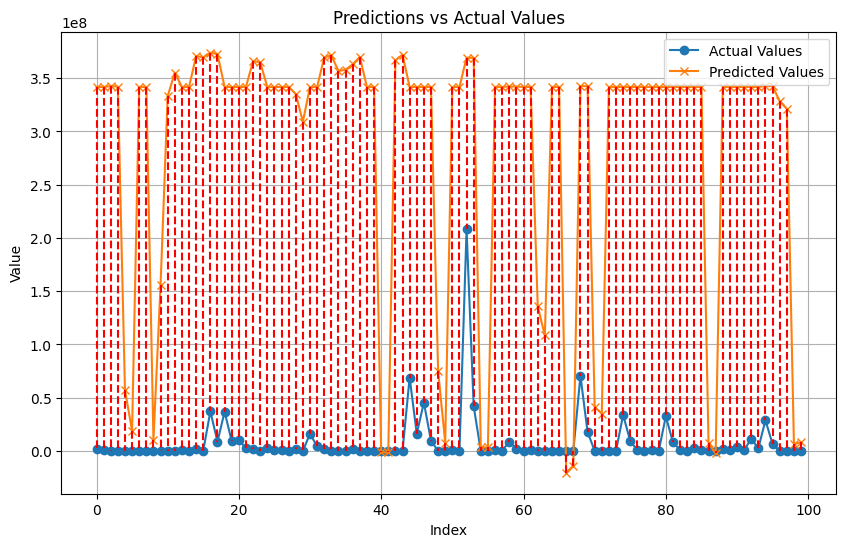

In [37]:
# Calculate the differences
differences = predictions - actuals

# Create the plot
plt.figure(figsize=(10, 6))

# Plot actual and predicted values
plt.plot(actuals, label='Actual Values', marker='o')
plt.plot(predictions, label='Predicted Values', marker='x')

# Plot differences
for i in range(len(predictions)):
    plt.plot([i, i], [predictions[i], actuals[i]], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()